# Data wrangling & preliminary data anylsis 

This notebook contains the work performed with regard to our first approach with the CMU Movie Corpus and its different aspects, as well as data enrichment and preliminary analysis concerning our research subject.

To navigate more easily through the different parts of the notebook, feel free to refer to the Table of Contents just below.

<a id="0"></a> <br>
## Table of Contents
## Put it in place at the end

Before going into all of this, let's first import the necessary libraries for the notebook to function properly :

In [1]:
import requests
import pandas as pd
from time import sleep
import wikipedia
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

from helpers.readers import read_dataframe

## 1. The CMU Movie Corpus <a class="anchor" id="1"></a>

Our first point of focus was the discovery of the dataset we decided to work with for this project,the CMU Movie Corpus. The idea of this part is to load the data under a usable form, familiarizing with it and thus knowing more about how we could use it for further analyzes.

### 1.1 Importing the CMU Datasets <a class="anchor" id="1.1"></a>

#### The CMU Movie Plot Summaries dataset

In [2]:
cmu_summaries = read_dataframe(name='cmu/summaries', usecols=[
    "Wikipedia movie ID", 
    "Plot Summary"
])
cmu_summaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Wikipedia movie ID  42303 non-null  int32 
 1   Plot Summary        42303 non-null  string
dtypes: int32(1), string(1)
memory usage: 495.9 KB


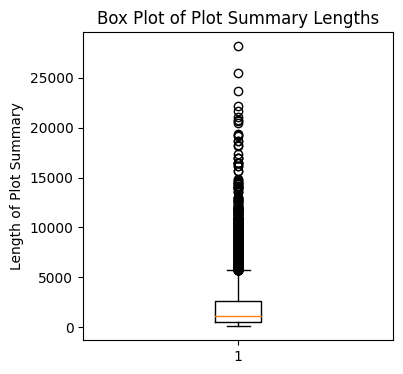

In [3]:
plt.figure(figsize=(4, 4))
plt.boxplot(cmu_summaries['Plot Summary'].apply(len))
plt.title('Box Plot of Plot Summary Lengths')
plt.ylabel('Length of Plot Summary')
plt.show()

A lot of plots only contain one sentence, however there are also with a lot of content. This is due to the popularity of movies, popular movie have more developed (longer) summaries in contrast to lesser known movies. 

In [4]:
def contains_link_or_special_char(summary):
    substrings = ['http', 'www', '|', '{', '[', '@', '#', '\\', '_', '^', '~', '`', '+', '=']
    return any(sub in summary for sub in substrings)

count = cmu_summaries['Plot Summary'].apply(contains_link_or_special_char).sum()
print(f"Percentage of summaries containing a link or special characters: {(count / len(cmu_summaries)) * 100:.2f}%")

Percentage of summaries containing a link or special characters: 22.14%


Almost a quarter of the summaries have a link or special character, this is probably due to the scrapping technics from 2013.





#### The CMU Movies & Characters dataset

In [5]:
cmu_movies = read_dataframe(name='cmu/movies', usecols=[
    "Wikipedia movie ID", 
    "Freebase movie ID", 
    "Movie name", 
    "Movie release date", 
    "Movie box office revenue", 
    "Movie runtime", 
    "Movie languages", 
    "Movie countries", 
    "Movie genres",
])
cmu_movies.head(2)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."


Under this form, many of the columns are unusable. We are thus going to transform the dataset to be able to have a clean basis to start investigating the data :

In [6]:
cmu_movies[cmu_movies['Movie countries'].str.contains('Language')]

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
46808,17906864,/m/047p8zv,Moonnam Mura,1988,NaN,NaN,"{""/m/0999q"": ""Malayalam Language""}","{""/m/0999q"": ""Malayalam Language""}","{""/m/01jfsb"": ""Thriller"", ""/m/02kdv5l"": ""Actio..."
67202,28964840,/m/0dgnjfj,Inakkilly,1984,NaN,NaN,{},"{""/m/0999q"": ""Malayalam Language"", ""/m/03rk0"":...","{""/m/068d7h"": ""Romantic drama""}"
72685,5093828,/m/0d2clf,Sex in Chains,1928-10-24,NaN,86.0,"{""/m/06ppq"": ""Silent film"", ""/m/04306rv"": ""Ger...","{""/m/084n_"": ""Weimar Republic"", ""/m/04306rv"": ...","{""/m/0hn10"": ""LGBT"", ""/m/06ppq"": ""Silent film""..."


3 rows contain "Language" inside their country field, let's manually fix this.

In [7]:
cmu_movies.loc[46808, 'Movie countries'] = '{"/m/03rk0": "India"}'
cmu_movies.loc[67202, 'Movie countries'] = '{"/m/03rk0": "India"}'
cmu_movies.loc[67202, 'Movie languages'] = '{"/m/0999q": "Malayalam Language"}'
cmu_movies.loc[72685, 'Movie countries'] = '{"/m/084n_": "Weimar Republic", "/m/0345h": "Germany"}'

Out of curiosity, let's check if movie languages contain divine [Deseret](https://en.wikipedia.org/wiki/Deseret_alphabet), for example could they contain this: `\\ud801\\udc16\\ud801\\udc32\\ud801\\udc49\\ud801\\udc4b\\ud801\\udc4c\\ud801\\udc32` 

In [8]:
cmu_movies[cmu_movies["Movie languages"].str.contains("\\\\ud")]

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
1825,30296135,/m/0g4ytpz,"If Not Us, Who?",2011-02-17,NaN,124.0,"{""/m/0gtg"": ""\ud801\udc16\ud801\udc32\ud801\ud...","{""/m/0345h"": ""Germany""}","{""/m/03g3w"": ""History"", ""/m/02p0szs"": ""Histori..."
7855,31099422,/m/0gh6j94,We Have a Pope,2011-04-15,NaN,104.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/06nm1"":...","{""/m/0f8l9c"": ""France"", ""/m/03rjj"": ""Italy""}","{""/m/07s9rl0"": ""Drama"", ""/m/01z4y"": ""Comedy""}"
20807,30296704,/m/0g5qmbz,Pina,2011-02-13,14620458.0,103.0,"{""/m/0k0sv"": ""Croatian language"", ""/m/02bjrlw""...","{""/m/0f8l9c"": ""France"", ""/m/07ssc"": ""United Ki...","{""/m/04rlf"": ""Music"", ""/m/0jtdp"": ""Documentary""}"
25679,33270910,/m/0c1sm3j,In Darkness,2011-09-02,1024295.0,145.0,"{""/m/05qqm"": ""Polish Language"", ""/m/0cjk9"": ""U...","{""/m/05qhw"": ""Poland"", ""/m/0d060g"": ""Canada"", ...","{""/m/02p0szs"": ""Historical fiction"", ""/m/07s9r..."
30562,33584636,/m/0hgqwmn,Hotel Lux,2011-10-27,NaN,102.0,"{""/m/02h40lc"": ""English Language"", ""/m/0gtg"": ...","{""/m/0345h"": ""Germany""}","{""/m/01z4y"": ""Comedy""}"
68137,33597212,/m/0hgrd5g,Three Quarter Moon,2011-09-30,NaN,95.0,"{""/m/02hwyss"": ""Turkish Language"", ""/m/0gtg"": ...","{""/m/0345h"": ""Germany""}","{""/m/0556j8"": ""Buddy film"", ""/m/0hqxf"": ""Famil..."


For the sake of `UTF-8` let's remove the divine Desert code. For the curious the divine message was: `('𐐖', '𐐲', '𐑉', '𐑋', '𐑌', '𐐲')`.

In [9]:
cmu_movies.loc[1825, "Movie languages"] = '{"/m/04306rv": "German Language"}'
cmu_movies.loc[7855, "Movie languages"] = '{"/m/02bjrlw": "Italian Language", "/m/06nm1": "Spanish Language", "/m/064_8sq": "French Language", "/m/04h9h": "Latin Language", "/m/02h40lc": "English Language", "/m/05qqm": "Polish Language", "/m/04306rv": "German Language"}'
cmu_movies.loc[20807, "Movie languages"] = '{"/m/0k0sv": "Croatian language", "/m/02bjrlw": "Italian Language", "/m/06b_j": "Russian Language", "/m/06nm1": "Spanish Language", "/m/064_8sq": "French Language", "/m/05zjd": "Portuguese Language", "/m/02h40lc": "English Language", "/m/06zvd": "Slovenian language", "/m/04306rv": "German Language", "/m/02hwhyv": "Korean Language"}'
cmu_movies.loc[25679, "Movie languages"] = '{"/m/05qqm": "Polish Language", "/m/0cjk9": "Ukrainian Language", "/m/0880p": "Yiddish Language", "/m/04306rv": "German Language"}'
cmu_movies.loc[30562, "Movie languages"] = '{"/m/02h40lc": "English Language", "/m/06b_j": "Russian Language", "/m/04306rv": "German Language"}'
cmu_movies.loc[68137, "Movie languages"] = '{"/m/02hwyss": "Turkish Language", "/m/04306rv": "German Language"}'

Some movies don't have a complete release data information in the format: `YYYY-MM-DD`. To fix this we will split the release date into three columns: year, month, and day.

In [10]:
cmu_movies['Movie release Year'] = cmu_movies['Movie release date'].str.split('-').str[0].astype('Int64')
cmu_movies['Movie release Month'] = cmu_movies['Movie release date'].str.split('-').str[1].astype('Int64')
cmu_movies['Movie release Day'] = cmu_movies['Movie release date'].str.split('-').str[2].astype('Int64')
cmu_movies.drop(columns=['Movie release date'], inplace=True)

The movies languages, countries and genres contain freebase identifier. Freebase not being around anymore, and to access easily the languages, countries and genres we will seperate the freebase codes from the strings we need.

In [11]:
cmu_movies['parsed languages'] = cmu_movies['Movie languages'].apply(ast.literal_eval)
cmu_movies['language codes'] = cmu_movies['parsed languages'].apply(lambda x: ','.join(list(x.keys())))
cmu_movies['languages'] = cmu_movies['parsed languages'].apply(lambda x: ','.join([val.replace(' Language', '') for val in list(x.values())]))
cmu_movies.drop(columns=['Movie languages', 'parsed languages'], inplace=True)

cmu_movies['parsed countries'] = cmu_movies['Movie countries'].apply(ast.literal_eval)
cmu_movies['countries codes'] = cmu_movies['parsed countries'].apply(lambda x: ','.join(list(x.keys())))
cmu_movies['countries'] = cmu_movies['parsed countries'].apply(lambda x: ','.join(list(x.values())))
cmu_movies.drop(columns=['Movie countries', 'parsed countries'], inplace=True)

cmu_movies['parsed genres'] = cmu_movies['Movie genres'].apply(ast.literal_eval)
cmu_movies['genres codes'] = cmu_movies['parsed genres'].apply(lambda x: ','.join(list(x.keys())))
cmu_movies['genres'] = cmu_movies['parsed genres'].apply(lambda x: ','.join(list(x.values())))
cmu_movies.drop(columns=['Movie genres', 'parsed genres'], inplace=True)

Let's only keep the columns we need.

In [12]:
cmu_movies_freebase = cmu_movies[['Freebase movie ID', 'language codes', 'countries codes', 'genres codes']].copy()
cmu_movies.drop(columns=['Freebase movie ID', 'language codes', 'countries codes', 'genres codes'], inplace=True)

cmu_movies.rename(columns={
    'languages': 'Movie languages',
    'countries': 'Movie countries',
    'genres': 'Movie genres'
}, inplace=True)
cmu_movies = cmu_movies[['Wikipedia movie ID', 'Movie name', 'Movie release Year', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres', 
                 'Movie release Month', 'Movie release Day']]

cmu_movies['Movie languages'] = cmu_movies['Movie languages'].astype('string')
cmu_movies['Movie countries'] = cmu_movies['Movie countries'].astype('string')
cmu_movies['Movie genres'] = cmu_movies['Movie genres'].astype('string')
cmu_movies['Movie release Year'] = pd.to_numeric(cmu_movies['Movie release Year'], downcast='integer')
cmu_movies['Movie release Month'] = pd.to_numeric(cmu_movies['Movie release Month'], downcast='integer')
cmu_movies['Movie release Day'] = pd.to_numeric(cmu_movies['Movie release Day'], downcast='integer')

cmu_movies_freebase['Freebase movie ID'] = cmu_movies_freebase['Freebase movie ID'].astype('string')
cmu_movies_freebase['language codes'] = cmu_movies_freebase['language codes'].astype('string')
cmu_movies_freebase['countries codes'] = cmu_movies_freebase['countries codes'].astype('string')
cmu_movies_freebase['genres codes'] = cmu_movies_freebase['genres codes'].astype('string')

In [13]:
cmu_movies.head(2)
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Wikipedia movie ID        81741 non-null  int32  
 1   Movie name                81741 non-null  string 
 2   Movie release Year        74839 non-null  Int16  
 3   Movie box office revenue  8401 non-null   float64
 4   Movie runtime             61291 non-null  float32
 5   Movie languages           81741 non-null  string 
 6   Movie countries           81741 non-null  string 
 7   Movie genres              81741 non-null  string 
 8   Movie release Month       42667 non-null  Int8   
 9   Movie release Day         39373 non-null  Int8   
dtypes: Int16(1), Int8(2), float32(1), float64(1), int32(1), string(4)
memory usage: 4.3 MB


Our cmu_movies dataframe thus contains the Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase. (Tab-separated; columns.)
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

We will perform similar operations for the characters dataset :

In [14]:
cmu_characters = read_dataframe(name='cmu/characters', usecols=[
    "Wikipedia movie ID",
    "Freebase movie ID",
    "Movie release date",
    "Character name",
    "Actor DOB",
    "Actor gender",
    "Actor height",
    "Actor ethnicity",
    "Actor name",
    "Actor age at movie release",
    "Freebase character/actor map ID",
    "Freebase character ID",
    "Freebase actor ID",
])


In [15]:
cmu_characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Wikipedia movie ID               450669 non-null  int32  
 1   Freebase movie ID                450669 non-null  string 
 2   Movie release date               440674 non-null  string 
 3   Character name                   192794 non-null  string 
 4   Actor DOB                        344524 non-null  string 
 5   Actor gender                     405060 non-null  string 
 6   Actor height                     154824 non-null  float32
 7   Actor ethnicity                  106058 non-null  string 
 8   Actor name                       449441 non-null  string 
 9   Actor age at movie release       292556 non-null  float32
 10  Freebase character/actor map ID  450669 non-null  string 
 11  Freebase character ID            192804 non-null  string 
 12  Fr

Similar to CMU movies, the release date of the movie isn't `YYYY-MM-DD` accross all rows, we will apply the same strategy.

In [16]:
cmu_characters['Movie release Year'] = cmu_characters['Movie release date'].str.split('-').str[0].astype('Int64')
cmu_characters['Movie release Month'] = cmu_characters['Movie release date'].str.split('-').str[1].astype('Int64')
cmu_characters['Movie release Day'] = cmu_characters['Movie release date'].str.split('-').str[2].astype('Int64')
cmu_characters.drop(columns=['Movie release date'], inplace=True)

Let's do the same for the characters date of birth, but let's first check out of curiosity of course, if the actor's date of birth has some rows in [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601) format.

In [17]:
cmu_characters[cmu_characters["Actor DOB"].str.contains("T")]

,Wikipedia movie ID,Freebase movie ID,Character name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,Movie release Year,Movie release Month,Movie release Day
2255,9205349,/m/02806zq,<NA>,1930-01-01T00:00:00-04:00,M,NaN,<NA>,Ahmed Ramzy,NaN,/m/02vbjtl,<NA>,/m/02pn6m5,1955,<NA>,<NA>
39805,35021411,/m/0j63lyh,<NA>,1961-08-04T19:24-10:00,M,1.854,/m/04y8_bm,Barack Obama,NaN,/m/0lyywdw,<NA>,/m/02mjmr,2012,3,15
69266,11160368,/m/02r22fr,<NA>,1961-08-04T19:24-10:00,M,1.854,/m/04y8_bm,Barack Obama,NaN,/m/0h0zv08,<NA>,/m/02mjmr,2008,<NA>,<NA>
85802,10573364,/m/02qj4k0,<NA>,1930-01-01T00:00:00-04:00,M,NaN,<NA>,Ahmed Ramzy,NaN,/m/02vc7rc,<NA>,/m/02pn6m5,<NA>,<NA>,<NA>
102093,24124394,/m/07k7ldh,<NA>,1961-08-04T19:24-10:00,M,1.854,/m/04y8_bm,Barack Obama,NaN,/m/0h0_pds,<NA>,/m/02mjmr,2009,<NA>,<NA>
118688,34333475,/m/0hzr2vb,<NA>,1961-08-04T19:24-10:00,M,1.854,/m/04y8_bm,Barack Obama,NaN,/m/0mzr2b6,<NA>,/m/02mjmr,2011,4,<NA>
142871,7451665,/m/0kv7wh,<NA>,1930-01-01T00:00:00-04:00,M,NaN,<NA>,Ahmed Ramzy,NaN,/m/045z9sd,<NA>,/m/02pn6m5,1971,<NA>,<NA>
155360,9232940,/m/02812z4,<NA>,1930-01-01T00:00:00-04:00,M,NaN,<NA>,Ahmed Ramzy,NaN,/m/02vd09q,<NA>,/m/02pn6m5,1956,<NA>,<NA>
246747,10772229,/m/02qpj8l,<NA>,1930-01-01T00:00:00-04:00,M,NaN,<NA>,Ahmed Ramzy,NaN,/m/02vc4h0,<NA>,/m/02pn6m5,<NA>,<NA>,<NA>
249209,28778357,/m/0ddg765,<NA>,1961-08-04T19:24-10:00,M,1.854,/m/04y8_bm,Barack Obama,NaN,/m/0h403qh,<NA>,/m/02mjmr,2009,2,16


Let's take this into account when we are creating three columns: year, month and day for the actor's date of birth.

In [18]:
cmu_characters['Actor DOB'] = cmu_characters['Actor DOB'].str.split('T', expand=True)[0]
cmu_characters['Actor DOB Year'] = cmu_characters['Actor DOB'].str.split('-').str[0].astype('Int64')
cmu_characters['Actor DOB Month'] = cmu_characters['Actor DOB'].str.split('-').str[1].astype('Int64')
cmu_characters['Actor DOB Day'] = cmu_characters['Actor DOB'].str.split('-').str[2].astype('Int64')
cmu_characters.drop(columns=['Actor DOB'], inplace=True)

Let's extract the freebase codes to seperate dataframe (exception for `Freebase actor ID` we will need it later). 

In [19]:
cmu_characters_freebase = cmu_characters[['Freebase movie ID', 'Freebase character/actor map ID', 'Freebase character ID',]].copy()
cmu_characters.drop(columns=['Freebase movie ID', 'Freebase character/actor map ID', 'Freebase character ID', ], inplace=True)

cmu_characters = cmu_characters[['Wikipedia movie ID', 'Movie release Year', 'Character name', 'Actor DOB Year', 'Actor gender', 
                                 'Actor height', 'Actor ethnicity', 'Actor name', 'Actor age at movie release', 'Freebase actor ID', 
                                 'Movie release Month', 'Movie release Day', 'Actor DOB Month', 'Actor DOB Day']]

cmu_characters['Actor gender'] = cmu_characters['Actor gender'].astype('category')

cmu_characters['Movie release Year'] = pd.to_numeric(cmu_characters['Movie release Year'], downcast='integer')
cmu_characters['Actor DOB Year'] = pd.to_numeric(cmu_characters['Actor DOB Year'], downcast='integer')
cmu_characters['Actor age at movie release'] = pd.to_numeric(cmu_characters['Actor age at movie release'], downcast='integer')
cmu_characters['Movie release Month'] = pd.to_numeric(cmu_characters['Movie release Month'], downcast='integer')
cmu_characters['Movie release Day'] = pd.to_numeric(cmu_characters['Movie release Day'], downcast='integer')
cmu_characters['Actor DOB Month'] = pd.to_numeric(cmu_characters['Actor DOB Month'], downcast='integer')
cmu_characters['Actor DOB Day'] = pd.to_numeric(cmu_characters['Actor DOB Day'], downcast='integer')

cmu_characters_freebase['Freebase movie ID'] = cmu_characters_freebase['Freebase movie ID'].astype('string')
cmu_characters_freebase['Freebase character/actor map ID'] = cmu_characters_freebase['Freebase character/actor map ID'].astype('string')
cmu_characters_freebase['Freebase character ID'] = cmu_characters_freebase['Freebase character ID'].astype('string')

cmu_characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Wikipedia movie ID          450669 non-null  int32   
 1   Movie release Year          440674 non-null  Int16   
 2   Character name              192794 non-null  string  
 3   Actor DOB Year              344524 non-null  Int16   
 4   Actor gender                405060 non-null  category
 5   Actor height                154824 non-null  float32 
 6   Actor ethnicity             106058 non-null  string  
 7   Actor name                  449441 non-null  string  
 8   Actor age at movie release  292556 non-null  float32 
 9   Freebase actor ID           449854 non-null  string  
 10  Movie release Month         290872 non-null  Int8    
 11  Movie release Day           273887 non-null  Int8    
 12  Actor DOB Month             330658 non-null  Int8    
 13 

Our 'cmu_characters' dataframe thus contains Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase. Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID

#### Add other datasets here from the CMU depending on what we analyse further down !

### 1.2 Insights on CMU's metadata state <a class="anchor" id="1.2"></a>

We have loaded the data under an exploitable form, but lets us now look if everything that is in this dataframe is usable further down the road :

####  Exploring the movies dataset

From ealier, we know that the movies dataset has 81741 entries.

Checking if all entries correspond to unique movies:

In [20]:
print('We have',cmu_movies['Wikipedia movie ID'].isna().sum(),'missing Wikipedia movie IDs')
print('We have',len(cmu_movies['Wikipedia movie ID'].unique()),'unique Wikipedia movie Ids in the dataset')
print('We have',len(cmu_movies['Movie name'].unique()),'unique movie names in the dataset')

We have 0 missing Wikipedia movie IDs
We have 81741 unique Wikipedia movie Ids in the dataset
We have 75478 unique movie names in the dataset


All wikipedia movie IDs are unique, but not all movie names. Might be some duplicate movie names. Some examples of movie names that are shared by several wikipedia movie IDs ?

In [21]:
# We group the films by Movie names and retrieve their Wiki Movie ID numbers
duplicate_movie_names = cmu_movies.groupby('Movie name')['Wikipedia movie ID'].nunique()
# We filter those for duplicate movie names
duplicate_movie_names = duplicate_movie_names[duplicate_movie_names > 1]

# We Get a list of duplicate movie names
duplicate_movie_names_list = duplicate_movie_names.index.tolist()

# We create a DataFrame containing only the rows with duplicate movie names
duplicates = cmu_movies[cmu_movies['Movie name'].isin(duplicate_movie_names_list)]

# We finally print the DataFrame with duplicate movie names
duplicates.head()

,Wikipedia movie ID,Movie name,Movie release Year,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie release Month,Movie release Day
5,13696889,The Gangsters,1913,NaN,35.0,"Silent film,English",United States of America,"Short Film,Silent film,Indie,Black-and-white,C...",5,29
6,18998739,The Sorcerer's Apprentice,2002,NaN,86.0,English,South Africa,"Family Film,Fantasy,Adventure,World cinema",<NA>,<NA>
13,171005,Henry V,1989,10161099.0,137.0,English,United Kingdom,"Costume drama,War film,Epic,Period piece,Drama...",11,8
24,31983669,Road to Life,1931,NaN,104.0,Russian,Soviet Union,Drama,9,30
43,26878691,Mysterious Island,1982,NaN,100.0,Standard Mandarin,Hong Kong,"Action/Adventure,Wuxia,Martial Arts Film,Chine...",<NA>,<NA>


In [22]:
cmu_movies[cmu_movies['Movie name'] == 'The Sorcerer\'s Apprentice']

,Wikipedia movie ID,Movie name,Movie release Year,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie release Month,Movie release Day
6,18998739,The Sorcerer's Apprentice,2002,NaN,86.0,English,South Africa,"Family Film,Fantasy,Adventure,World cinema",<NA>,<NA>
18151,18997933,The Sorcerer's Apprentice,1955,NaN,13.0,English,"United States of America,West Germany",Short Film,5,<NA>
49733,12621957,The Sorcerer's Apprentice,2010,215283742.0,111.0,English,United States of America,"Science Fiction,Adventure,Fantasy,Comedy,Drama...",7,8


As we can expect, these correspond to "generic" movie names that are given to different movies in our dataset.

--> **Retrieving the movies based on their ID and not their name will be safer to avoid duplicates.**

A very important element of the movies if we aim to quantify the success of the latter is its revenue. Let us look at how this looks in our cmu_movies dataset :

In [24]:
print('Out of the 81741 movies in the dataset,', cmu_movies['Movie box office revenue'].isna().sum(),'have no exploitable Box office revenue values.')

Out of the 81741 movies in the dataset, 73340 have no exploitable Box office revenue values.


**--> That's 89.7 % of all the movie entries, only counting the NaN values. Complicated to know the extent to which we would be able to use revenue values without enriching it, it may be limiting otherwise.**



We then also want to know about the characteristics of the movies themselves. First, how many entries have non-valid / missing Movie languages info ?

In [26]:
print('We have',cmu_movies['Movie languages'].isna().sum(),'entries that have missing (NA) movie languages info')
print('We have', cmu_movies['Movie languages'].apply(lambda x: len(x) == 0).sum(),'entries that have wrong movie languages info')

We have 0 entries that have missing (NA) movie languages info
We have 13865 entries that have wrong movie languages info


That's 16.96% of the total movie entries.
In the other 67 876 rows with existing info, let's look at the distribution.

A movie can of course contain several "Movie languages".  As this column is a string, what's done below is to simply, from a string and assuming that languages are separated by a ',' withing the string, extract the different languages for each movie to be able to count them using a dictionnary. We also define a function that, based on a 'count' dictionnary, will plot the corresponding histogram of 20 most present elements.


In [27]:
def working_strip(curr_string, separator):
    li = []
    string_left = True
    working_string = curr_string
    while string_left:
        loc = working_string.find(separator)
        string_left = (loc != -1)
        if string_left :
            while (working_string[:loc])[0] == ' ' :
                  working_string = working_string[1:]
                  loc-=1 
            li.append(working_string[:loc])
            working_string = working_string[loc + 1:]
        else:
            
            while working_string[:loc][0] == ' ' :
                  working_string = working_string[1:]
                  loc-=1
            li.append(working_string)       
    return li

def string_to_str_lists(str_input):
        process = working_strip(str_input, ',')
        return process

def count_dict(df, column):
    languages_count_dic = {}

    for j, value in enumerate(df.loc[:,column]):
    
        if len(value) != 0 :

            curr_movie_languages = string_to_str_lists(value)
            for lang in curr_movie_languages :
            
                if lang in languages_count_dic :
                    languages_count_dic[lang] += 1 

                else :
                    languages_count_dic[lang] = 1
                #print(languages_count_dic)
    return languages_count_dic


def plot_count_histogram(count_dict,element) :

    sorted_counts = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)

    top_elements, top_counts = zip(*sorted_counts[:20])


    plt.figure(figsize=(12, 6))
    plt.bar(top_elements, top_counts)
    plt.xlabel(element)
    plt.ylabel('Counts')
    plt.title(element+' Counts Histogram')
    plt.xticks(rotation=75) 
    
    plt.xticks(fontsize=8)
    
    plt.show()  

In [28]:
lang_count_dict = count_dict(cmu_movies,'Movie languages')
print('We have a total of', len(lang_count_dict),'distinct languages in which movies have been made/translated')

We have a total of 211 distinct languages in which movies have been made/translated


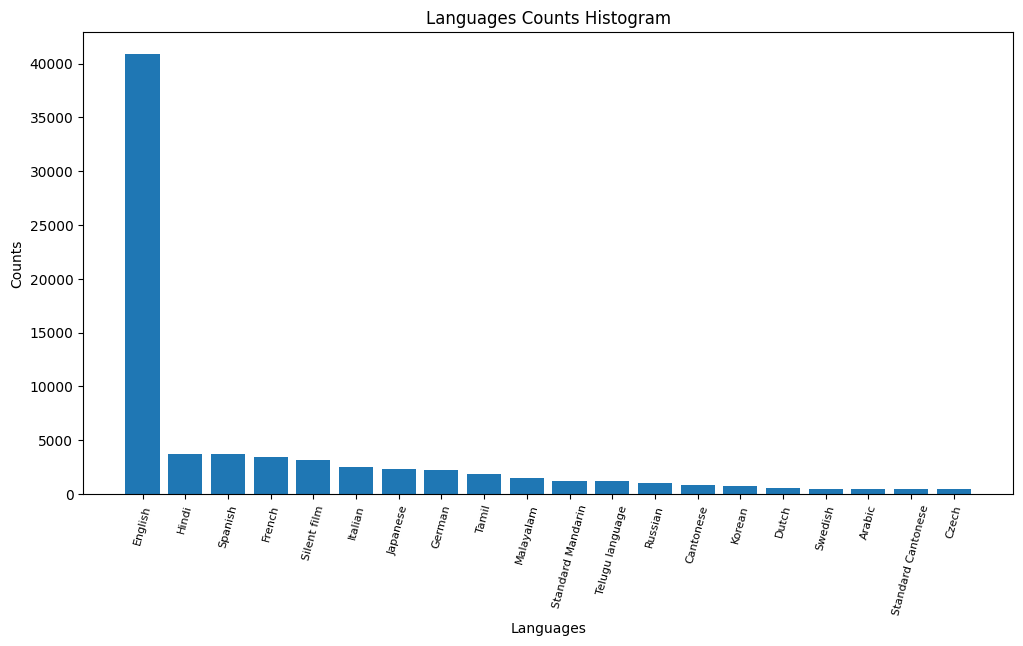

In [29]:
plot_count_histogram(lang_count_dict,'Languages')

**--> 40 891 movies have been distributed in english : careful if doing analysis, huge number compared to the others (3744 for Hindi, even less for the others). This could very well lead to a bias if we had to draw analysis based on the movie language.**


Let us now do a similar analysis, but with the Movie countries :

In [30]:
print('We have',cmu_movies['Movie countries'].isna().sum(),'entries that have missing (NA) movie languages info')
print('We have', cmu_movies['Movie countries'].apply(lambda x: len(x) == 0).sum(),'entries that have wrong movie languages info')

We have 0 entries that have missing (NA) movie languages info
We have 8154 entries that have wrong movie languages info


Roughly 10% of the data. Are these ones also the ones with "wrong" Movie languages info?

In [31]:
countries_and_languages_missing = len(cmu_movies[cmu_movies.apply(lambda row: len(row['Movie languages']) == 0 and len(row['Movie countries']) == 0, axis=1)])
print(countries_and_languages_missing)

5853


There thus is 5853 movies for which both the movie languages and countries are missing, which is reasonable on the 81k movies. Once again, let us focus rapidly on the exploitable data :

In [32]:
countries_count_dict = count_dict(cmu_movies,'Movie countries')
print('We have a total of', len(countries_count_dict),'distinct countries in which movies have been made')

We have a total of 145 distinct countries in which movies have been made


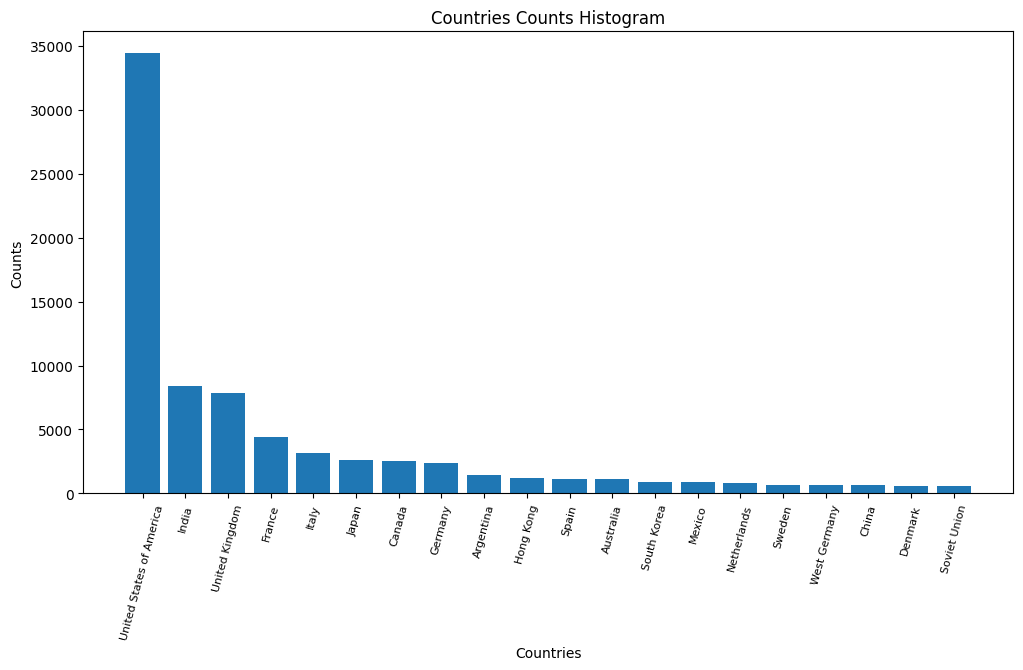

In [33]:
plot_count_histogram(countries_count_dict,'Countries')

**--> Once again, we have one element that is extremely present. This time, it is the United States. Be careful about any biases, once again.**

Let us run a third and final similar analysis, but with movie genres :

In [34]:
print('We have',cmu_movies['Movie genres'].isna().sum(),'entries that have missing (NA) movie languages info')
print('We have', cmu_movies['Movie genres'].apply(lambda x: len(x) == 0).sum(),'entries that have wrong movie languages info')

We have 0 entries that have missing (NA) movie languages info
We have 2294 entries that have wrong movie languages info


Very few numbers of movies with lacking movie languages information, pretty good !

In [35]:
genres_count_dict = count_dict(cmu_movies,'Movie genres')
print('We have a total of', len(genres_count_dict),'distinct genres in the movies of our dataset')

We have a total of 363 distinct genres in the movies of our dataset


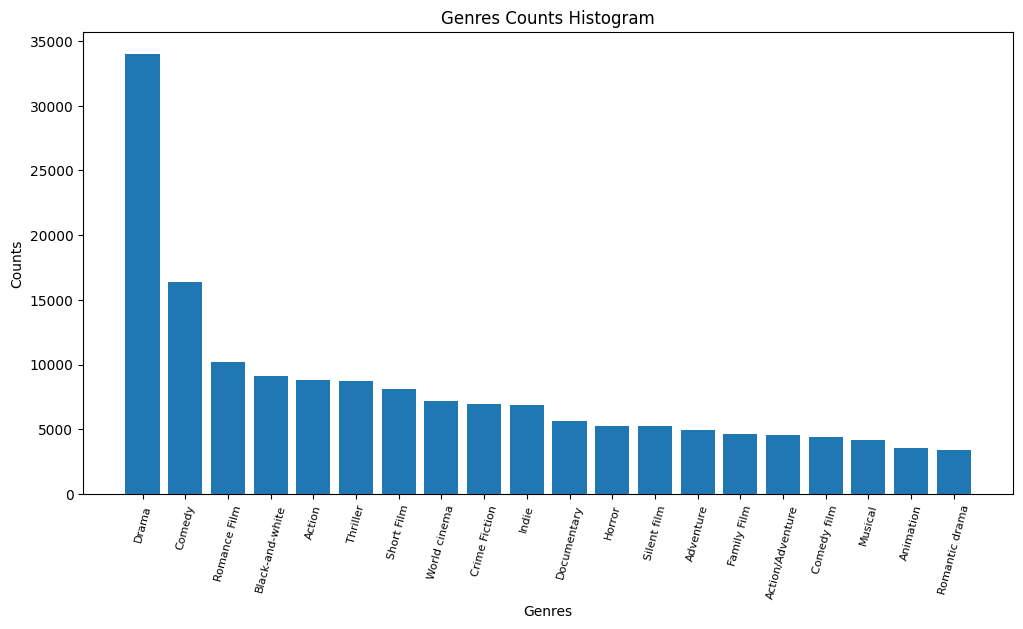

In [36]:
plot_count_histogram(genres_count_dict,'Genres')

363 distinct genres is huge. Looking at the histogram above, we have clues about the reason this number is so high : <br>

- We have Action and Adventure up there, but a third one "Action/Adventure" is also considered as a distinct genre from the two. 

- "Romantic Drama" is different from "Drama" as it should, and if other subgenres from "Drama" are present, this could inflate the numbers of distinct genres as well.

Let's just see how many of these 363 genres are extremely present in our dataset (let's set an arbitrary threshold at 1000 occurences at first) :

In [37]:
main_genres = [genre for genre, count in genres_count_dict.items() if count > 1000]
print(len(main_genres))

41


Only 41 genres with that threshold. A minority of genres are the ones that are more present, which makes sense as the ones we obtain just above are rather generic, while some more 'niche' or specific movie types will most likely be less common.

Regarding those main themes present in our dataset, let's first say these 41 genres. Let's see how closely each are related with each other using a heatmap that will count the occurence of both genres in a movie.

In [40]:
%%time

occurences_counts = {genre:[] for genre in main_genres}

for genre in main_genres :
    for other_genre in main_genres :
        if genre != other_genre :
            count = (cmu_movies['Movie genres'].str.contains(genre) & cmu_movies['Movie genres'].str.contains(other_genre)).sum()
            occurences_counts[genre].append((other_genre,count))

#Converting the dic to a dataframe
occurences_data = {
    genre: {other_genre: count for other_genre, count in counts}
    for genre, counts in occurences_counts.items()
}

genres_occurences_df = pd.DataFrame(occurences_data)
last_row = genres_occurences_df.iloc[-1]

# Move the last row to the first position and shift the other rows downwards
df_heatmap = pd.concat([last_row.to_frame().T, genres_occurences_df.iloc[:-1]])

CPU times: total: 2min 32s
Wall time: 2min 36s


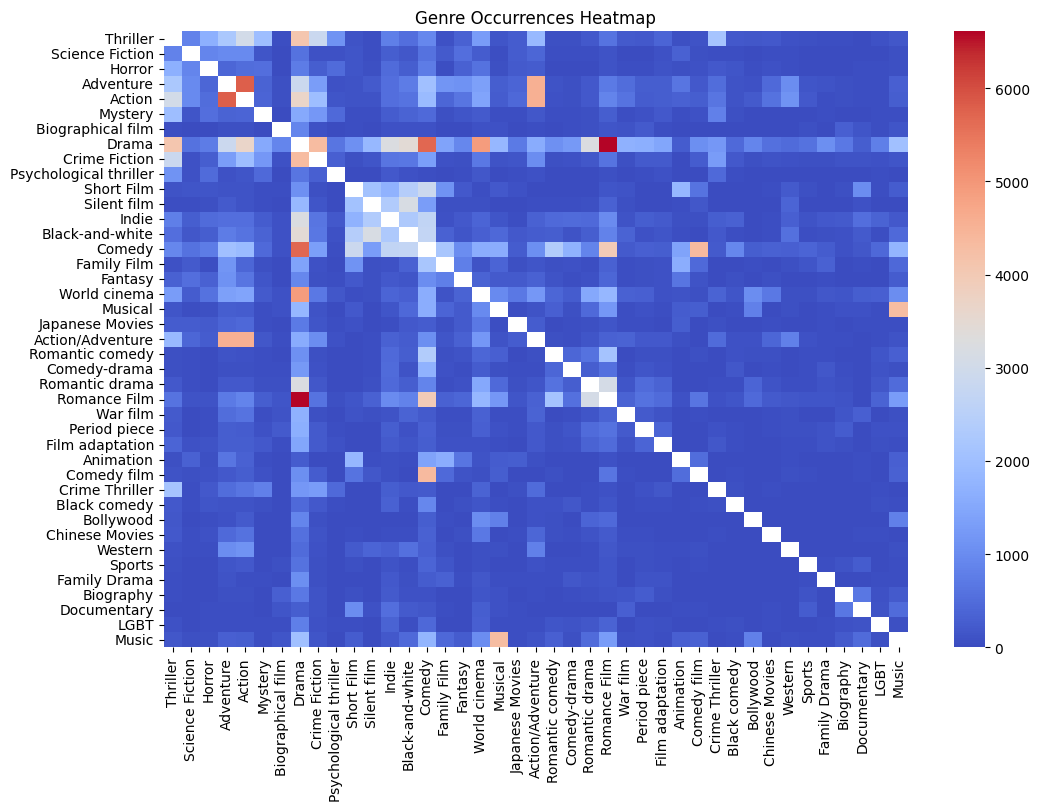

In [41]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_heatmap, cmap='coolwarm')
plt.title('Genre Occurrences Heatmap')
plt.show();

**Many different dual association of genres are found a lot in the movies dataset. Some of them are interesting, others could be more worrying :**

- The most common association is "Drama" - "Romance Film", followed by "Drama" - "Comedy"

- "Action" and "Adventure" are found together a lot as well but we can see that a third genre is well correlated with both of them as well "Action/Adventure". Problematic, as this is repetitive. Which one do we decide to keep ? 

- A lot of "Black-And-White" films are also "Indie", "Short Film", "Silent Film" and also "Comedy" apparently (makes sense).

To see an example in the case of Action/Adventure, let's quickly look at what is present in the "Movie genres" column for movies that also have "Action/Adventure" :

In [42]:
action_adventure = cmu_movies[cmu_movies['Movie genres'].str.contains('Action/Adventure', case=False, na=False)]
action_adventure.head(10)

,Wikipedia movie ID,Movie name,Movie release Year,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie release Month,Movie release Day
11,24229100,Lady Snowblood 2: Love Song of Vengeance,1974,NaN,89.0,Japanese,Japan,"Crime Fiction,Thriller,Japanese Movies,World c...",<NA>,<NA>
43,26878691,Mysterious Island,1982,NaN,100.0,Standard Mandarin,Hong Kong,"Action/Adventure,Wuxia,Martial Arts Film,Chine...",<NA>,<NA>
49,261237,The Gods Must Be Crazy,1980,34331783.0,109.0,"Afrikaans,English",South Africa,"Adventure,Action/Adventure,Indie,World cinema,...",<NA>,<NA>
54,4951456,Kinjite: Forbidden Subjects,1989,3416846.0,97.0,English,United States of America,"Crime Fiction,Action/Adventure,Action,Thriller",<NA>,<NA>
75,2647998,The Human Tornado,1976,NaN,86.0,English,United States of America,"Action/Adventure,Action Comedy,Cult,Blaxploita...",<NA>,<NA>
86,31026308,Sombra Verde,1954,NaN,85.0,Spanish,Mexico,"Action/Adventure,Thriller,Drama,Adventure,Worl...",<NA>,<NA>
92,25413122,Drums in the Deep South,1951,NaN,87.0,English,United States of America,"Action/Adventure,Western,War film",<NA>,<NA>
101,27556929,Deadly Voyage,1996,NaN,90.0,English,"United States of America,United Kingdom","Thriller,Action Thrillers,Horror,Television mo...",<NA>,<NA>
102,4300418,The Hero: Love Story of a Spy,2003,NaN,182.0,Hindi,India,"Thriller,Action Thrillers,Adventure,World cine...",4,11
132,22985953,Beachhead,1954,1400000.0,90.0,,United States of America,"Action/Adventure,Action,Drama,Film adaptation,...",2,5


As expected, there's some "duplicates" : some movies have "Action/Adventure" as well as "Action", "Adventure". 

Overall, this analysis of the genres underlines the complexity and the number of genres present in this dataset. As a case by case analysis may be impossible to do, we should maybe limit the number of genres present to clean it up. Maybe by adding another dataset..?

----------------------------------------------------------------------------------------

Let us now finally look at the information that we have about the movie runtime and release dates.
How many movie runtime values and release years are missing from the dataframe ?

In [43]:
missing_runtime_count = cmu_movies['Movie runtime'].isnull().sum()
missing_ry_count = cmu_movies['Movie release Year'].isnull().sum()
print(f'The number of entries with missing runtime information is: {missing_runtime_count}')
print(f'The number of entries with missing Release Year information is: {missing_ry_count}')


The number of entries with missing runtime information is: 20450
The number of entries with missing Release Year information is: 6902


A quarter of our entries are missing their runtime information, which is significant, while only 7k of them are missing release year information. In any case, we could try to enrich, once again, these two columns to complete the information of the CMU Movie corpus.

How are the movie release years and Runtime distributed throughout the dataset ?

In [44]:
print(sorted(cmu_movies['Movie runtime'].dropna().unique()))
print(sorted(cmu_movies['Movie release Year'].dropna().unique()))

[0.0, 0.03, 0.05, 0.083333336, 0.1, 0.11666667, 0.15, 0.2, 0.21666667, 0.26666668, 0.3, 0.33333334, 0.36666667, 0.4, 0.41666666, 0.45, 0.46666667, 0.5, 0.56666666, 0.5833333, 0.6, 0.6333333, 0.65, 0.6666667, 0.68333334, 0.7, 0.71666664, 0.73333335, 0.75, 0.76666665, 0.78333336, 0.81666666, 0.8333333, 0.8833333, 0.9, 0.93333334, 0.96666664, 1.0, 1.0833334, 1.1, 1.11, 1.1333333, 1.15, 1.1666666, 1.1833333, 1.25, 1.2666667, 1.4833333, 1.5, 1.6, 1.6666666, 1.75, 1.7833333, 1.83, 1.8333334, 1.9166666, 2.0, 2.15, 2.22, 2.2333333, 2.28, 2.3, 2.48, 2.5, 2.5333333, 3.0, 3.1166666, 3.1666667, 3.25, 3.3333333, 3.34, 3.38, 3.45, 3.5, 3.5666666, 3.6166666, 3.7, 3.75, 3.8833334, 3.9666667, 4.0, 4.25, 4.35, 4.4166665, 4.5, 4.6666665, 5.0, 5.25, 5.42, 5.5, 5.5833335, 5.59, 5.75, 5.766667, 6.0, 6.1, 6.15, 6.17, 6.18, 6.2, 6.28, 6.3333335, 6.43, 6.5, 6.51, 6.55, 6.5666666, 6.57, 6.78, 6.8166666, 6.866667, 6.9, 6.95, 7.0, 7.07, 7.13, 7.14, 7.21, 7.22, 7.25, 7.27, 7.32, 7.5, 7.57, 7.59, 7.6, 7.75, 7.9, 7.

In [45]:
display(cmu_movies[cmu_movies['Movie runtime'] == 1079281.0])
display(cmu_movies[cmu_movies['Movie runtime'] == 14400.0])

,Wikipedia movie ID,Movie name,Movie release Year,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie release Month,Movie release Day
12804,10815585,Zero Tolerance,1995,NaN,1079281.0,English,United States of America,"Thriller,Crime Fiction,Action,Indie,Action/Adv...",<NA>,<NA>


,Wikipedia movie ID,Movie name,Movie release Year,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie release Month,Movie release Day
62962,32441022,Modern Times Forever,<NA>,NaN,14400.0,,,Documentary,<NA>,<NA>


Here we printed the unique values present in both the release years and runtime columns. We can observe that in the release years, a single value seems off, 1010. In the movie runtimes however, the movie runtime values are extremely spread out, from 0.03 to huge values such as 1 079 281. 
When looking at the particular film with this runtime value, we can see that it's most likely an error and that the value should be the movie box office revenue. If we look at the second one, we see that it indeed lasts 14400 minutes (240 hours) 'Modern Times Forever'. There's thus maybe outliers, but also movies with 'wrong' values.

For the very short values, this could be due, in the dataset, to the presence of very short black and white films (as we saw that we have many films dating from earlier eras, as confirmed just below) and we should be careful with this information.

For the release years : (removing faulty data previous to 1800)

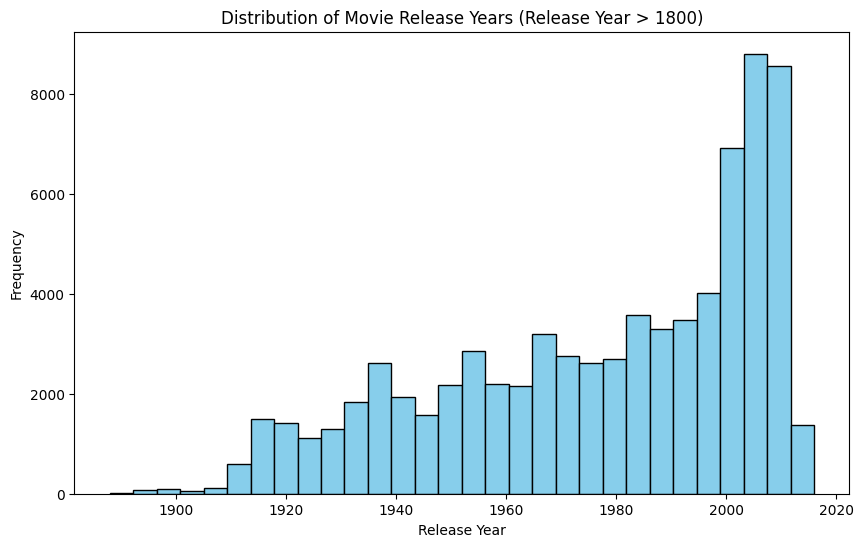

In [46]:
filtered_df = cmu_movies[cmu_movies['Movie release Year'] > 1800]

# Create a histogram of movie release years
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['Movie release Year'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Release Years (Release Year > 1800)')
plt.xlabel('Release Year')
plt.ylabel('Frequency')

plt.show()

Once again, we can observe that the CMU movie corpus has an increasing trend for the release years of its movies (The last bin decrease due to the fact that we are not considering any movies past 2016 in the CMU). We'll have to take that into account if we perform a temportal analysis using this data !

------------------------------------

In conclusion about the Metadata state of the CMU and how we could use it for our project, we can say that :

- The Wikipedia Movie IDs can be used to define a unique movie, as movie names might be shared by several movies throughout the dataset.

- Unfortunately, much of the information about the revenue of the movies is missing, which makes it complicated

- The movie metadata present in the CMU movie corpus is heavily shifted towards english-speaking and US movies, we have less much informatio about movies produced in other countries than in the United States, and the main language in which the films were produced is of course english.

- The number of genres present in the dataset is important, and some are very precise and detailed, making them only present in certain movies. Some of them are also intertwined and repetitive. We could try to determine more general genres in which we could fit more movies.

- The runtime information of a quarter of our movies is absent in most movies and we have durations ranging from 0 to the second longest movie ever made, with 14 400 minutes. Concerning the release year values however, the vast majority of them are present.



All of these information do not directly to any research questions or project that we have, but they tell us two things.

- First, we have some pitfalls regarding biases or distribution that we should be careful about and not fall into.

- We know on which parts we need to enrich our data. For our specific research questions of course, we do not have information about the complete crew of movies, including directors. However, we have a basis to work on and we know what we be great to enrich (runtime value, revenue of the movies mostly) for our future work.


This concludes our first analyzes of the CMU metadata about the movies. Let us now turn to the characters metadata.

####  Exploring the characters dataset

The _characters_ dataframe is supposed to have the metadata of 450.669 individual characters.

--> How many missing character names do we have ?

In [48]:
print('We have',cmu_characters['Character name'].isna().sum(),'missing character names')
print('We have',cmu_characters_freebase['Freebase character ID'].isna().sum(),'missing character IDs')

We have 257875 missing character names
We have 257865 missing character IDs


57% of the characters names are missing and the same number (nearly) of missing freebase Character IDs. Depending on what we aim to do with the NLP data, this might be problematic.

Let's now check the number of movies for which we have (supposedly) character metadata :

In [49]:
print(cmu_characters['Wikipedia movie ID'].nunique())

64330


We only have 64330 unique movie IDs in the character's dataset, while we have 81741 in the movies dataset. Are these these 64330 unique movie IDs part of the movies dataframe ?

In [50]:
characters_movie_ids = cmu_characters['Wikipedia movie ID'].unique()
movies_movie_ids = cmu_movies['Wikipedia movie ID'].unique()

all_ids_in_movies = all(id in movies_movie_ids for id in characters_movie_ids)

if all_ids_in_movies:
    print("All 'Wikipedia Movie ID' values in the 'characters' dataframe  are contained in the 'movies' DataFrame.")
else:
    print("Not all 'Wikipedia Movie ID' values in the 'characters'  DataFrame are contained in the 'movies' DataFrame.")

All 'Wikipedia Movie ID' values in the 'characters' dataframe  are contained in the 'movies' DataFrame.


All of the Wikipedia Movie IDs present in the characters data are also present in the movies data, a quick double check but which reassures us about what we have in the characters metadata.

In these 64330 movies, let's see if there are any movies for which all the characters are missing :

In [51]:
movies_with_missing_character_names = cmu_characters.groupby('Wikipedia movie ID')['Character name'].apply(lambda x: x.isna().all())
count = movies_with_missing_character_names.sum()
print(count)

31759


31.759 out of the 64.330 movies have all characters names that are missing, but how many total characters does that correspond to ?

In [52]:
character_counts = cmu_characters.groupby('Wikipedia movie ID')['Character name'].apply(lambda x: x.isna().sum())

sum_of_characters_for_all_missing = character_counts[movies_with_missing_character_names].sum()

print("Sum of character counts for movies with all characters missing:", sum_of_characters_for_all_missing)


Sum of character counts for movies with all characters missing: 136857


--> By removing the 31.759 movies for which all character data is missing, we get rid of 136.857 of the 257.875 characters for which the name + freebase character name ID is missing <br>

Still half~ of the characters for which names are missing is part of movies where not everything is missing. Perhaps only one character name has been saved in those movies while the rest is missing, but that is not counted here.

For the general idea of our project, this will most likely not be problematic as character names will not be a primary focus. What is of more substantial importance would be the NLP data about the personas of these characters, but this will be treated in a next part.

About actors now : How many unique actors do we have in here ?

In [53]:
print('We have', cmu_characters['Actor name'].nunique(),'unique actors in the dataset')

We have 134078 unique actors in the dataset


This number may be wrong due to different ways of writing actor names, etc. Let's compare it with the number of unique freebase actor IDs that we have :

In [54]:
print('We have', cmu_characters['Freebase actor ID'].nunique(),'unique actors IDs in the dataset')

We have 135760 unique actors IDs in the dataset


More unique actors IDs than unique actor names : this most likely means that some actors names are indeed repeated while their unique IDs are safer when considering 'unique' actors. This should be what we use for filtering !

Another important consideration is, of course, the genders of the actors present in the dataset : let's look at its distribution.

In [55]:
cmu_characters.head(2)

,Wikipedia movie ID,Movie release Year,Character name,Actor DOB Year,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase actor ID,Movie release Month,Movie release Day,Actor DOB Month,Actor DOB Day
0,975900,2001,Akooshay,1958,F,1.62,<NA>,Wanda De Jesus,42.0,/m/03wcfv7,8,24,8,26
1,975900,2001,Lieutenant Melanie Ballard,1974,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0346l4,8,24,8,15


In [56]:
#Getting all the rows with unique actors
unique_actors_df = cmu_characters.drop_duplicates(subset='Freebase actor ID', keep='first')
#print(len(unique_actors_df))
#How many rows with unknown gender data
unknown_gender_count = unique_actors_df[unique_actors_df['Actor gender'].isna() | (unique_actors_df['Actor gender'] == 'NaN')]['Actor name'].nunique()
print(unknown_gender_count)

37981


We have ~38 000 persons with missing gender data.

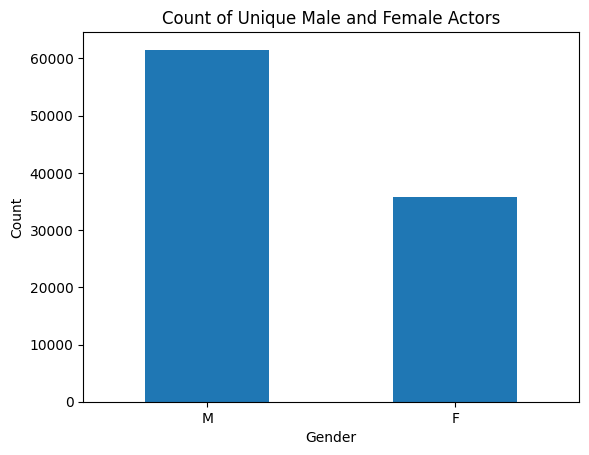

In [57]:
gender_counts = unique_actors_df['Actor gender'].value_counts()

# Plot the bar chart
gender_counts.plot(kind='bar', rot=0)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Count of Unique Male and Female Actors')
plt.show();

On the data we have in the characters dataset, 63% are male actors for 47% female actors. The difference is not too big but we must be careful, as this may not represent the reality of role distributions. Even if it does, we should still be careful about it.

Then and finally, the casts composure and the actors landscape may very well change during the years, and that is also something we need to be aware of.

Do we have actors from all eras ? Let us see this by using their date of birth :

In [58]:
df_cleaned = unique_actors_df.dropna(subset=['Actor DOB Year'])
print(len(df_cleaned))
print(df_cleaned['Actor DOB Year'].min(),df_cleaned['Actor DOB Year'].max())

58573
19 9900



We only have 57 982 unique actors with some valid year DOB info, and we see that we have false information such as 19 or 9900 in some rows.

We need another source of information to fill these, maybe another dataset...?

But let us look at, once again, what we already have :

In [59]:
print(np.sort(df_cleaned['Actor DOB Year'].unique()))

[19 183 195 852 1075 1474 1498 1796 1804 1828 1829 1835 1836 1837 1838
 1839 1842 1843 1844 1845 1846 1847 1848 1849 1850 1851 1852 1853 1854
 1855 1856 1857 1858 1859 1860 1861 1862 1863 1864 1865 1866 1867 1868
 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882
 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896
 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910
 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924
 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938
 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952
 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966
 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980
 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2011 2050 2896 2936 9900]


Let's only take the 'valid' ones from 1796 to 2011.

58557


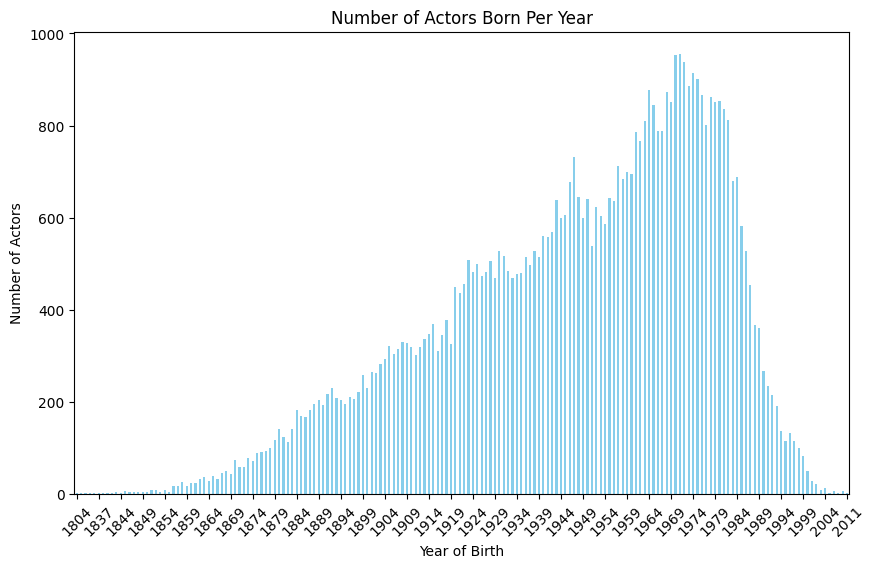

In [60]:
df_dobs = df_cleaned[(df_cleaned['Actor DOB Year'] >= 1804) & (df_cleaned['Actor DOB Year'] <= 2011)]


actor_dob_df = df_dobs[['Actor DOB Year']].astype(int)
print(len(actor_dob_df))


actor_count_per_year = actor_dob_df['Actor DOB Year'].value_counts().sort_index()


plt.figure(figsize=(10, 6))
actor_count_per_year.plot(kind='bar', color='skyblue')
plt.xlabel('Year of Birth')
plt.ylabel('Number of Actors')
plt.title('Number of Actors Born Per Year')

plt.xticks(range(0, len(actor_count_per_year.index), 5), actor_count_per_year.index[::5], rotation=45)

plt.show();

The number of actors is steadily increasing throughout the years. The rapid decrease at the very end is because we are considering, in that plot, the date of birth of actors, hence not many actors active in 2013 at most were born in 2011...

What about the age of the actor at the movie's release ?

In [61]:
print(df_cleaned['Actor age at movie release'].unique())

[ 4.200e+01  2.700e+01  3.200e+01  3.300e+01  2.300e+01  5.200e+01
  5.600e+01  3.000e+01  5.700e+01  6.600e+01  4.700e+01  5.800e+01
  4.300e+01  5.000e+01  5.500e+01  4.000e+01  3.500e+01  6.000e+00
  6.200e+01  5.100e+01  2.800e+01        nan  3.100e+01  3.400e+01
  4.400e+01  2.600e+01  3.800e+01  6.000e+01  3.700e+01  4.600e+01
  2.400e+01  3.900e+01  2.200e+01  1.600e+01  3.600e+01  2.900e+01
  1.700e+01  1.900e+01  4.800e+01  1.000e+00  2.100e+01  1.400e+01
  6.700e+01  2.000e+01  5.900e+01  2.500e+01  5.400e+01  9.000e+00
  7.100e+01  5.300e+01  6.900e+01  4.500e+01  4.100e+01  7.300e+01
  7.700e+01  4.900e+01  1.800e+01  6.500e+01  7.400e+01  6.400e+01
  8.300e+01  6.100e+01  7.500e+01  6.800e+01  6.300e+01  1.100e+01
  7.000e+01 -2.900e+01  7.000e+00  8.000e+00  7.200e+01  1.000e+01
  1.300e+01  1.500e+01  1.200e+01  7.800e+01  8.400e+01  7.900e+01
  8.500e+01 -1.200e+01  8.000e+01  7.600e+01  5.000e+00 -1.800e+01
  8.600e+01  8.100e+01  4.000e+00  8.900e+01  8.200e+01  2.000

Once again, lots of "wrong" invalid values. Let us only take the clean ones.

49738


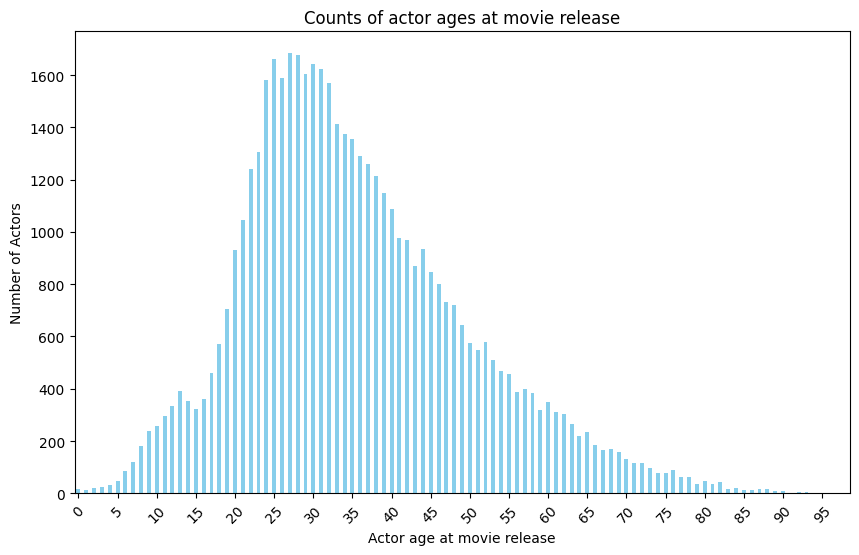

In [62]:
df_aamr = unique_actors_df[(unique_actors_df['Actor age at movie release'] >= 0) & (unique_actors_df['Actor age at movie release'] <= 100)]

actor_aamr_df = df_aamr[['Actor age at movie release']].astype(int)
print(len(actor_aamr_df))

aamr_per_year = actor_aamr_df['Actor age at movie release'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
aamr_per_year.plot(kind='bar', color='skyblue')
plt.xlabel('Actor age at movie release')
plt.ylabel('Number of Actors')
plt.title('Counts of actor ages at movie release')

plt.xticks(range(0, len(aamr_per_year.index), 5), aamr_per_year.index[::5], rotation=45)

plt.show();

There's a real peak of the number of actors around 20 to 35 years, after which it starts to decline and before which the numbers are low as well (but increasing).

Once again, this analysis of the characters metadata indicates that the CMU, for optimal research, should be enriched and cleaned with the actors Date of births, their gender and their age at the movie relase. 

### The CMU NLP data

........... (put Arthur's work here !) -Arthur: either here or after IMdb as u guys prefer

## The IMDb data

To be able to improve the quality of our work and of our research questions, we need some additional information about the critical acclamation, the different persons part of movies crews, from directors to makeup artists. 

In addition, adding another dataset may very well be of use to improve the quality of the data that we have in CMU, which we saw can be lacking on some points.

We thus decide to use the IMDb datasets as our main source of enrichment, as they contain much of the information we need. We load the latter before going into analysing their composition :

In [ ]:
# use read_dataframe, u may need to modify it
imdb_people = pd.read_csv('data/IMDb/name.basics.tsv', sep='\t', na_values=['\\N'])
#imdb_info = pd.read_csv('data/IMDb/title.basics.tsv', sep='\t', na_values=['\\N'])
#imdb_principals = pd.read_csv('data/IMDb/title.principals.tsv', sep='\t', na_values=['\\N'])
#imdb_ratings = pd.read_csv('data/IMDb/title.ratings.tsv', sep='\t', na_values=['\\N'])

As our aim is to be able to enrich our CMU corpus with IMDb info by merging the different datasets, we will run a few things to see what's missing and what's present in the IMDb metadata. First, about movies/shows etc. that are contained in the imdb_info dataset :

In [ ]:
print('Number of entries :',len(imdb_info))
print('Number of unique IMDb titles:', imdb_info['tconst'].nunique())

The info_imdb only contains unique IMDb titles, there doesn't seem to be any repetition based on the tconst attributes.

In [ ]:
print('How many Title primary names are missing? -->', imdb_info['primaryTitle'].isna().sum())

print('How many start years are missing in the dataset? -->',imdb_info['startYear'].isna().sum())

print('How many end years are missing in the dataset? -->',imdb_info['endYear'].isna().sum())

print('How many entries lack info about the runtime? -->', imdb_info['runtimeMinutes'].isna().sum())

print('How many entries lack info about the genres? -->', imdb_info['genres'].isna().sum())

- Nearly no primary names for title lacking that's good.

- Not that much start years missing, only for 13.4% of the entries. For our CMU dataset, this is the column that would be equivalent to the "Movie release Year" : high chance we can enrich our data with it !

- A vast majority of end years missing but this is normal as this is only filled for shows, not movies.

- Not that many missing genres, only for ~5% of our dataset. Some chance that this info could be compared with what's in the CMU and maybe decide to use these genres instead of the CMU ones if they're more interesting ?

- 70% of the runtime value missing. That still leaves 3M movies/shows where info is available for our 80k movie/shows of the CMU, which is still a lot. But there's risk that IMDb won't maybe be optimal to retrieve the Runtime value.

- Also, no info about the box office of movies if we wanted to use it to quantify the movie's success in our characters/personas analysis if we want to talk about how successful these are. If we want the revenue, we need to add an additional dataset.

Then, about the ratings, which could be used for the success of films :

In [ ]:
print('Number of entries :',len(imdb_ratings))
print('Number of unique IMDb titles:', imdb_ratings['tconst'].nunique())

Only unique entries but for only 1.36 million entries out of the 10.2 millions that we have in imdb_info. Hopefully they're all valid :

In [ ]:
print('How many ratings are missing? -->', imdb_ratings['averageRating'].isna().sum())

Nice, at least we do not have missing values. Problem is that ratings might not be that accurate if they're based on just a very few number of votes. How many number of votes do ratings have approximately ?

In [ ]:
mean_votes = imdb_ratings['numVotes'].mean()
median_votes = imdb_ratings['numVotes'].median()
std_dev_votes = imdb_ratings['numVotes'].std()

# Display the results
print(f"Mean number of votes: {mean_votes:.2f}")
print(f"Median number of votes: {median_votes}")
print(f"Standard deviation of votes: {std_dev_votes:.2f}")

No histogram there as the disparity is too big between what's in the huge dataset, it doesn't render any interesting information. Median interesting here : As many films with 26 votes or less than ones that have more than. 

The most famous movies and shows will have a lot of votes while many niche / unknown films or even films made in countries where people are not used to go rate films on IMDb (i.e a lot of people) won't have votes on here.

Difficult to know if the movies in the CMU would get ratings with a sufficient number of votes to really reflect popular opinion on the movie. We'll have to try ! Otherwise, we could very well scrap Critics from other websites, if available on the wikipedia page.

##### IMDb people 

In [ ]:
print('Number of entries :',len(imdb_people))
print('Number of unique people in the dataset:', imdb_people['nconst'].nunique())

And who are these people exactly ?

In [ ]:
fig = plt.figure(figsize=(4, 10))
ax = fig.add_subplot(111)

(imdb_people.primaryProfession
    .str.split(',', expand=True)
    .stack(dropna=True)
    .value_counts(ascending=True)
).plot.barh(
    ax=ax,
)

ax.set(
    xscale='log'
);

We can observe that this datasets coveres a very large range of job types in the cinematic production 

## Merging CMU dataset with the IMDb dataset

As we previously said, CMU could be used to enrich our data as well as get new information that may be very useful for the rest of our work.

Add additional information, can't do it now

A naive approach would be to merge on the title of the movies or on a combination of movie name and year for instance. However, we saw earlier in this notebook that to be completely sure about correctly collecting unique movies from the CMU dataset, Wikipedia Movie ID were more reliable.

However, this ID is not present in the IMDb dataset. The only id that we have to identify the movies is the IMDB id. We need to find a way to retrieve the IMDb ids of the movies present in our CMU dataset.

### Crawling Wikipedia and querying Wikidata

If only there existed a mapping between Wikipedia ID / Freebase ID to IMDb IDs, the merging could be done. 

We notice that the same string also appears in the URL of the movie page on the IMDb website. With the help of an external library, [wikipedia](https://wikipedia.readthedocs.org/en/latest/), we can get the content of the Wikipedia page of a movie from its Wikipedia ID in the CMU dataset. We also notice that the IMDb page of the movie is most of the times referenced in the Wikipedia pages of the movies, meaning that we can link the two by crawling Wikipedia. However, this approach might fail if the IMDb page is not included anywhere in the Wikipedia page, or the Wikipedia page is not retrievable from its page ID.

For these cases, we follow an alternative approach. In the Wikidata page of a movie, both the Freebase ID and the IMDb ID are listed. We can use the [Wikidata Query Service](https://query.wikidata.org) to match these two together.

The `helpers.external.crawl_wikipedia` and `helpers.external.crawl_wikidata` methods are used in `helpers.external.extract_cmu_imdb_mapping` to get such mappings. The whole process takes around 24 hours but can be improved by engineering the requests sent to Wikipedia by the external library. Since we only need to do this once, we opt to focus on the other parts and stick with the implementation of the external library. `helpers.external.extract_cmu_imdb_mapping` generates such mappings by the two methods, aggregates them, and stores the final mapping (and the most complete one) in `./generated/wp2imdb.csv`. The file is available in the repository but can be regenerated simply by running this function.

```python
from helpers.external import extract_cmu_imdb_mapping
extract_cmu_imdb_mapping()
```

We use this mapping in the rest of this section to merge the two datasets.

In [ ]:
mapping_01 = pd.read_csv('generated/wp2imdb_01.csv')
mapping_02 = pd.read_csv('generated/wp2imdb_02.csv')
mapping = pd.read_csv('generated/wp2imdb.csv')

#len(mapping_01), len(mapping_02), len(mapping.imdb.unique()), len(cmu_movies)

There are thus 57 IMDb movies that are duplicated in the first method, and 11 in the second one:

In [ ]:
duplicates_01 = mapping_01[mapping_01.imdb.duplicated(keep=False)]
duplicates_02 = mapping_02[mapping_02.imdb.duplicated(keep=False)]

len(duplicates_01.imdb.unique()), len(duplicates_02.imdb.unique())

Let's analyze the two mappings separately. First, we merge the duplicated mappings with the CMU table to get the titles. Then we add the URL of the Wikipedia page to check them more easily.

In [ ]:
#duplicates_01 = pd.merge(left=duplicates_01, right=cmu_movies, on='wikipedia', how='left').sort_values(by='imdb')
#duplicates_01['url'] = duplicates_01.wikipedia.apply(lambda pageid: wikipedia.page(pageid=pageid).url)
#display(duplicates_01, display_id=False)

### Finish the analysis of the merging with what's left in Sepehr's notebook

### Matching IMDb & CMU informations :


Let's say we decide to only keep the 74k out of 82k movies where we can retrieve the IMDb ID per the Wiki data crawling method as our dataset. A first thing that we can do is use the mapping produced to get, from IMDb, only the persons that are part of movies in the CMU :

In [ ]:
imdb_people_exploded = imdb_people.copy()
imdb_people_exploded['knownForTitles'] = imdb_people['knownForTitles'].str.split(',')
imdb_people_exploded = imdb_people_exploded.explode(['knownForTitles'])


merged_ipe = pd.merge(imdb_people_exploded, mapping_02, how='inner', left_on='knownForTitles', right_on='imdb')
unique_matched_persons = merged_ipe.drop_duplicates(subset='nconst', keep='first')

In [ ]:
matched_imdb_people = pd.merge(imdb_people, unique_matched_persons[['nconst']], on='nconst', how='inner')
len(matched_imdb_people)

In [ ]:
fig = plt.figure(figsize=(4, 10))
ax = fig.add_subplot(111)

(matched_imdb_people.primaryProfession
    .str.split(',', expand=True)
    .stack(dropna=True)
    .value_counts(ascending=True)
).plot.barh(
    ax=ax,
)

ax.set(
    xscale='log'
);

From the original 12M~ number of unique persons originally present in the _imdb_people_ dataset, we can extract approximately 1.5M that worked, in all fields of the production, on movies that are part of the CMU corpus, based on the matching between Freebase and IMDb IDS.


However, each of these persons in the imdb_people have different 'PrimaryProfessions' : we do not know yet what eact job they occupied for each film. However, we have the principals dataset which has all the interesting information about that :

In [ ]:
imdb_principals.head(5)

In [ ]:
matched_imdb_people.head(5)

We will take thus only 'nconst' and 'tconst' entities that belong to the CMU Movie corpus, thanks to our mapping and to the list of people just extracted before.

In [ ]:
tmp_principal_people = pd.merge(imdb_principals, matched_imdb_people[['nconst']], on='nconst', how='inner')
matched_principal_people = pd.merge(tmp_principal_people,mapping_02[['imdb']],left_on='tconst',right_on='imdb',how='inner')

In [ ]:
display(matched_principal_people)

This matched_principal_dataset contains the information about all the people that worked on the CMU Movies in all fields of the production ! We obtain 618 725 entries, which represent people with a specific job on a specific movie of the CMU.

This number may be lower than the 1.5M people obtained earlier due to the fact that we are not handling the 'principals' dataset, which contains different information than 'people'. How many unique persons does that represent for how many unique movies ?

In [ ]:
print(matched_principal_people['nconst'].nunique())
print(matched_principal_people['tconst'].nunique())

Once again a quick double check for the number of movies : we still have ~73.5K of them from the CMU. And we can see that this correspond to ~191 563 persons in total ! This could be a first indicator that the same faces can be found in different movies, at all stages of the production. 
However, we can also see for instance in the tt8355792 (two rows before the two very last ones above) that we only have information about the directors of the movie here. We most likely do not have complete information for all the 73 646 movies, but let's check how many unique people were part of each of those movies, and let's see how many directors are present in the dataframe :

In [ ]:
people_count_per_movie = matched_principal_people.groupby('tconst')['nconst'].nunique().reset_index()

# Rename the columns for clarity
people_count_per_movie.columns = ['tconst', 'people_count']

plt.hist(people_count_per_movie['people_count'], bins=range(1, max(people_count_per_movie['people_count']) + 2), align='left')

plt.xlabel('Number of People')
plt.ylabel('Number of Movies')
plt.title('Histogram of Number of People in Each Movie')

plt.show()

In [ ]:
director_counts = matched_principal_people[matched_principal_people['category'] == 'director']['nconst'].value_counts()
total_directors = director_counts.sum()
print('The number of individuals occupying a "director" role in the CMU Movies is ',total_directors)

That's two extremely relieving results ! We have a very few number of movies where a few numbers of people are reported for the cast, so much usable data, and we have a very big number of directors as well. How many of them are unique directors ?

In [ ]:
directors_df = matched_principal_people[matched_principal_people['category'] == 'director']

# Get the number of unique directors
num_directors = directors_df['nconst'].nunique()

# Display the result
print(f'The number of directors in the DataFrame is: {num_directors}')

That's great as well ! This means that we have a large number of directors that have directed many movies in the CMU movie corpus and that we can try to analyse how any changes in their cast, etc. have influenced their career, successes, etc.

What are the repartitions of jobs in this dataset ?

In [ ]:
fig = plt.figure(figsize=(4, 10))
ax = fig.add_subplot(111)

(matched_principal_people.category
    .str.split(',', expand=True)
    .stack(dropna=True)
    .value_counts(ascending=True)
).plot.barh(
    ax=ax,
)

ax.set(
    xscale='log'
);

We can observe that we have less diverse categories than in the imdb_people dataframe. However, this may be interesting to keep it to those categories, as it could allow to have a more 'tidied' way of proceeding.

### Enriching the rest of our data

IMDb provided with many additional information, especially about the directors themselves and their different teams. However, we still have some questions left unanswered as of now :

- How do we want to enrich the data with valid Box office values ? Can we also add the budget ? 

In [ ]:
movielens_metadata = pd.read_csv('data/MovieLens/movies_metadata.csv', usecols=["id","overview","title","vote_average","release_date"], delimiter=',')


In [ ]:
from ast import literal_eval

def convert_json_string(json_str):
    return literal_eval(json_str.replace("'", '"')) if pd.notnull(json_str) else None


In [ ]:
#df = pd.read_csv('data/MovieLens/movies_metadata.csv', converters={
#    'belongs_to_collection': convert_json_string,
#    'genres': convert_json_string,
#    'production_companies': convert_json_string,
#    'production_countries': convert_json_string,
#    'spoken_languages': convert_json_string
#})